# Setup

In [1]:
%load_ext cython
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division

import sys
sys.path.append('src')
sys.path.append('src/util')

import numpy as np
np.set_printoptions(edgeitems=5, precision=5)

import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('precision', 9)

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="whitegrid", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.axes_style({'xtick.minor.size': 0.5,'ytick.minor.size': 0.5})

# import pint
import time
import codetimer as ct
import gle_simulation_v2_1 as gle
import force

---
## Test Langevin Impulse integration

In [2]:
PI = np.pi
kBol = 1.3806485e-23
NREP, NAUX, NDIM = 1, 1, 1

# Physical data for water taken from [Water (data page)](https://en.wikipedia.org/wiki/Water_(data_page))
Te   = 303.15                 # [K] (30 deg C)
eta  = 0.8007e-3              # [Pa*s] = [kg/m/s] (@ 303.15 K)
rhof = 0.9956502e3            # [kg/m^3]          (@ 303.15 K)
rhop = 1.0*rhof               # [kg/m^3]
### Vesicle parameters ###
R = 1.0e-7                    # [m]
m = rhop*(4/3)*PI*R**3      # [kg]    particle mass 
gam0 = 6*PI*eta*R/m           # [1/s]   collision frequency
tau0 = (m/(3*PI*(R**2)*(eta*rhof)**0.5))**2  # [1/s]   collision frequency
nu1 = 0.25*gam0      # [1/s]

In [3]:
### Base units ###
Lc  = R                     # length      [m]
# Lc  = L0                    # length      [m]
Tc  = tau0                  # time        [s]
Ec  = m*(Lc/Tc)**2          # energy      [J]
Tec = Te                    # temperature [K]
### Derived units ###
Vc  = Lc/Tc                 # velocity    [m/s]
Mc  = Ec/Vc**2              # mass        [kg]
Nc  = Mc/Lc**3              # density     [kg/m^3]
Fc  = Ec/Lc                 # force       [N]

dt  = 1.0e-4*Tc     # [s]

## Cython

Here are generalized Langevin equation integrator things coded in Cython using extension types. This approach is probably slower than hard-coding the integrator and forces, but it's *far* more flexible and allows certain changes to be made at runtime.

**Wish list**:
* Dynamically (after compile-time) select precision via module-level attribute (see [this StackOverflow question](https://stackoverflow.com/questions/28749209/do-cython-extension-types-support-class-attributes))
* Handle arrays of `sigma`s and `theta`s to accommodate arbitrary number of auxiliary variables/equations
* Wrap the run function in a standard Python class (if that's doable), or something similar to get a more Pythonic interface
* Make the function handling the auxiliary variable integration (`AuxiliaryAdvance`) more general if the performance cost isn't too great; it can be combined with the `ImpulseVelocity` function since they use similar parameters.

**Note**:

Having each of integrator sub-functions (i.e., VelocityAdvance, PositionAdvance, etc.) retain their own copies of the parameters (e.g., mass, `theta`, `sigma`, etc.):

**advantages**:
* resulting code is somewhat cleaner
* easier to have custom parameters in each integrator sub-function like `self.im = 1/self.m` that helps reduce FLOPS

**disadvantages**:
* slows down between 5 to 10%; probably due to having to perform a separate attribute lookup each time one of the integrator sub-functions are called (or something).

### Fast 1D reference version

### Fast multidimensional version

In [15]:
%%cython -c=-O3 -c=-ffast-math
# --compile-args=cython.cdivision

import cython
from cython.parallel import prange
import numpy as np
cimport numpy as np

from c_gle_io import GLEInputOutput

import sys
sys.path.append('util')
from progressbar_simple import ProgressBar

cdef class Force:
    cpdef double evaluate(self, double X) except *:
        return 0

cdef class VelocityAdvance:
    cdef double mass
    cdef double imass

    def __cinit__(self, double mass):
        self.mass = mass
        self.imass = 1/mass

    cpdef double rhs(self, double F, double S) except *:
        return 0

cdef class ImpulseVelocityAdvance:
    cdef double theta, sigma
    cdef double theta_minus_one

    def __cinit__(self, double theta, double sigma):
        self.theta = theta
        self.sigma = sigma
        self.theta_minus_one = -(1 - theta)

    cpdef double rhs(self, double V, double W) except *:
        return 0

cdef class PositionAdvance:
    cpdef double rhs(self, double Vh, double Vi) except *:
        return 0

cdef class AuxiliaryAdvance:
    cdef double gamma, theta, sigma
    cdef double one_m_theta_x_gamma

    def __cinit__(self, double gamma, double theta, double sigma):
        self.gamma = gamma
        self.theta = theta
        self.sigma = sigma
        self.one_m_theta_x_gamma = (1 - theta)*gamma

    cpdef double rhs(self, double S, double Vh, double W) except *:
        return 0

cdef class LangevinIntegrator:
    cdef double dt
    
    cpdef double advance(self, int n, double[:,::1] X, double[:,::1] V, \
                         double[:,::1] S, double[:,::1] F) except *:
        return 0

cdef class LIVelocityAdvance(VelocityAdvance):
    cpdef double rhs(self, double F, double S) except *:
        return self.imass*F - S

cdef class LIImpulseVelocityAdvance(ImpulseVelocityAdvance):
    cpdef double rhs(self, double V, double W) except *:
        return self.theta_minus_one*V + self.sigma*W

cdef class LIPositionAdvance(PositionAdvance):
    cpdef double rhs(self, double Vh, double Vi) except *:
        return Vh + 0.5*Vi

cdef class LIAuxiliaryAdvance(AuxiliaryAdvance):
    cpdef double rhs(self, double S, double Vh, double W) except *:
        return self.theta*S - self.one_m_theta_x_gamma*Vh + self.sigma*W

cdef class LangevinImpulseIntegrator(LangevinIntegrator):
    cdef Force force
    cdef VelocityAdvance va
    cdef ImpulseVelocityAdvance iva
    cdef PositionAdvance pa
    cdef AuxiliaryAdvance sa
    cdef double mass, gamma, theta0, sigma0, theta1, sigma1
    cdef double dti2

    def __cinit__(self, Force force, double mass, double gamma, double theta0, \
                  double sigma0, double theta1, double sigma1, double dt):
        self.mass = mass
        self.gamma  = gamma
        self.theta0 = theta0
        self.sigma0 = sigma0
        self.theta1 = theta1
        self.sigma1 = sigma1
        
        self.va  = LIVelocityAdvance(mass)
        self.iva = LIImpulseVelocityAdvance(theta0, sigma0)
        self.pa  = LIPositionAdvance()
        self.sa  = LIAuxiliaryAdvance(gamma, theta1, sigma1)
        self.force = force
        
        self.dt   = dt
        self.dti2 = dt/2
    
    @cython.boundscheck(False)
    cpdef double advance(self, int n, double[:,::1] X, double[:,::1] V, \
                         double[:,::1] S, double[:,::1] F) except *:
        cdef double Vh, Vi, W
        cdef int NDIM = X.shape[1]
        
        for dim in range(NDIM):
            W = np.random.randn(1)
            Vh = V[n,dim] + self.dti2*self.va.rhs(F[n,dim], S[n,dim])
            Vi = self.iva.rhs(V[n,dim], W)
            X[n+1,dim] = X[n,dim] + self.dt*self.pa.rhs(Vh, Vi)
            S[n+1,dim] = self.sa.rhs(S[n,dim], Vh, W)
            F[n+1,dim] = self.force.evaluate(X[n,dim])
            V[n+1,dim] = Vh + Vi + self.dti2*self.va.rhs(F[n+1,dim], S[n+1,dim])
        return W


cdef class ConstantForce(Force):
    cdef double C0
    
    def __cinit__(self, C0):
        self.C0 = C0

    cpdef double evaluate(self, double X) except *:
        return self.C0

cdef class LinearForce(Force):
    cdef double C0, C1
    
    def __cinit__(self, double C0, double C1):
        self.C0 = C0
        self.C1 = C1

    cpdef double evaluate(self, double X) except *:
        return self.C0 + self.C1*X


cpdef run_fast(double[:,::1] X, double[:,::1] V, double[:,::1] S, double[:,::1] F, \
               LangevinIntegrator integrator, inout,                          \
               int NSTEPS, int NTDUMP, int NTOUT, int printout, int NDIM,  \
               int seed, no_store=False):
    cdef double Vh, Vi, W
    cdef int n, ntidx, didx, pidx, tidx
    
    cdef double dt = integrator.dt

    inout.open_traj_files()      # open trajectory HDF5 files for writing
    inout.init_io_storage(NSTEPS, NTOUT, NTDUMP) # init trajs for temp storage pos/vel
    np.random.seed(seed)

    with ProgressBar(NSTEPS, interval=1, unit='full') as pb:
        for ts in xrange(NSTEPS+1):
            n = ts % NTDUMP
            if n == 0:
                terminate = inout.dump_traj(ts, X, V, F, S, no_store=no_store)
                X[0] = X[-1]
                V[0] = V[-1]
                F[0] = F[-1]
                S[0] = S[-1]
                if terminate:
                    break
            if (ts % printout) == 0:
                pb.update(ts)
            integrator.advance(n, X, V, S, F)
    
    inout.close_traj_files()

---

In [5]:
deltat = 1.0e-4
mass   = m/Mc
gamma  = gam0*Tc
nu     = nu1*Tc
kT     = kBol*Te/Ec
sqrt2kTim = (2*kT/mass)**0.5

theta0 = np.exp(-gamma*deltat)
alpha0 = ((1 - theta0**2) / 2)**0.5
sigma0 = alpha0*sqrt2kTim

theta1 = np.exp(-nu*deltat)
alpha1 = ((1 - theta1**2) * nu / 2)**0.5
sigma1 = alpha1*sqrt2kTim

In [6]:
print 'sqrt2kT/m: {}'.format(sqrt2kTim)
print 'theta0: {}'.format(theta0)
print 'alpha0: {}'.format(alpha0)
print 'sigma0: {}'.format(sigma0)
print 'theta1: {}'.format(theta1)
print 'alpha1: {}'.format(alpha1)
print 'sigma1: {}'.format(sigma1)

sqrt2kT/m: 0.00110042277467
theta0: 0.999911115062
alpha0: 0.0094276714051
sigma0: 1.03744243263e-05
theta1: 0.999977778025
alpha1: 0.00222219753109
sigma1: 2.44535677302e-06


In [30]:
NSTEPS = 10000000
NTOUT = 1
NTDUMP = int(NSTEPS/1)
DUMPSIZE = int(NTDUMP/NTOUT)
printout = 1000

print 'NSTEPS = {}'.format(NSTEPS)
print 'NTOUT  = {}'.format(NTOUT)
print 'NTDUMP = {}  (DUMPSIZE is {})'.format(NTDUMP, DUMPSIZE)

NSTEPS = 10000000
NTOUT  = 1
NTDUMP = 10000000  (DUMPSIZE is 10000000)


---
### Cython fast multidimensional version

---

In [31]:
NTOUT = 1
NTDUMP = int(NSTEPS/1)
DUMPSIZE = int(NTDUMP/NTOUT)

print 'NSTEPS = {}'.format(NSTEPS)
print 'NTOUT  = {}'.format(NTOUT)
print 'NTDUMP = {}  (DUMPSIZE is {})'.format(NTDUMP, DUMPSIZE)

NSTEPS = 10000000
NTOUT  = 1
NTDUMP = 10000000  (DUMPSIZE is 10000000)


#### No compression

In [32]:
from c_gle_io import GLEInputOutput
try:
    inout.close_traj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

inout = GLEInputOutput(deltat, NREP, NAUX, NDIM, NSTEPS, NTOUT, NTDUMP, 'data/c_test_raw')
inout.setup(complevel=1, complib=None)
force = Force()
integrator = LangevinImpulseIntegrator(force, mass, gamma, theta0, sigma0, theta1, sigma1, deltat)

X = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
V = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
F = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
S = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)

Closing trajectory files. Data stored in:
	data


In [33]:
run_fast(X, V, Fry, S, integrator, inout,
         NSTEPS=NSTEPS, NTDUMP=NTDUMP, NTOUT=NTOUT, printout=printout, NDIM=NDIM, seed=1234567)

Progress:
[##################################################] 100.0% | ETA: 0m0s 
  --->  Elapsed time: 00:01:22.41

Closing trajectory files. Data stored in:
	data


In [41]:
xdata = inout.positions.copy(deep=True)

#### Compression

In [36]:
from c_gle_io import GLEInputOutput
try:
    inout11.close_traj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

inout11 = GLEInputOutput(deltat, NREP, NAUX, NDIM, NSTEPS, NTOUT, NTDUMP, 'data/c_test_cmp_nopreopen_fixed')
inout11.setup(complevel=9, complib='blosc:snappy')
force = Force()
integrator = LangevinImpulseIntegrator(force, mass, gamma, theta0, sigma0, theta1, sigma1, deltat)

X = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
V = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
F = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
S = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)

Closing trajectory files. Data stored in:
	data


In [35]:
run_fast(X, V, F, S, integrator, inout11,
         NSTEPS=NSTEPS, NTDUMP=NTDUMP, NTOUT=NTOUT, printout=printout, NDIM=NDIM, seed=1234567)

Progress:
[##################################################] 100.0% | ETA: 0m1s 
  --->  Elapsed time: 00:01:11.66

Closing trajectory files. Data stored in:
	data


In [37]:
run_fast(X, V, F, S, integrator, inout11,
         NSTEPS=NSTEPS, NTDUMP=NTDUMP, NTOUT=NTOUT, printout=printout, NDIM=NDIM, seed=1234567)

Progress:
[##################################################] 100.0% | ETA: 0m1s 
  --->  Elapsed time: 00:00:56.55

Closing trajectory files. Data stored in:
	data


In [38]:
from c_gle_io import GLEInputOutput
try:
    inout11.close_traj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

inout11 = GLEInputOutput(deltat, NREP, NAUX, NDIM, NSTEPS, NTOUT, NTDUMP, 'data/c_test_cmp_nopreopen_fixed')
inout11.setup(complevel=9, complib='blosc:lz4')
force = Force()
integrator = LangevinImpulseIntegrator(force, mass, gamma, theta0, sigma0, theta1, sigma1, deltat)

X = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
V = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
F = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
S = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)

Closing trajectory files. Data stored in:
	data


In [39]:
run_fast(X, V, F, S, integrator, inout11,
         NSTEPS=NSTEPS, NTDUMP=NTDUMP, NTOUT=NTOUT, printout=printout, NDIM=NDIM, seed=1234567)

Progress:
[##################################################] 100.0% | ETA: 0m0s 
  --->  Elapsed time: 00:00:56.81

Closing trajectory files. Data stored in:
	data


In [17]:
xdata11 = inout11.positions.copy(deep=True)

In [ ]:
(inout11.positions == inout.positions).all()

---

In [15]:
raw_X = pd.read_hdf('data/c_test_raw.all.h5', 'positions')

In [23]:
out = pd.HDFStore('data/c_test_cmp_blosc.all.h5', 'r')

In [24]:
out.open()

In [26]:
out['positions']

Run #                  Run 1
Coordinates                x
0.0001      -2.669467606e-10
0.0002      -1.033997400e-09
0.0003      -1.134364757e-09
0.0004      -1.222139880e-12
0.0005       1.479079182e-09
...                      ...
499.9996    -9.299635997e-02
499.9997    -9.299652308e-02
499.9998    -9.299668511e-02
499.9999    -9.299684646e-02
500.0000    -9.299700756e-02

[5000000 rows x 1 columns]

In [16]:
cmp_X = pd.read_hdf('data/c_test_cmp_blosc.all.h5', 'positions')

In [17]:
raw_X

Run #                  Run 1
Coordinates                x
0.0000       0.000000000e+00
0.0001      -2.669467606e-10
0.0002      -1.033997400e-09
0.0003      -1.134364757e-09
0.0004      -1.222139880e-12
...                      ...
499.9996    -9.299635997e-02
499.9997    -9.299652308e-02
499.9998    -9.299668511e-02
499.9999    -9.299684646e-02
500.0000    -9.299700756e-02

[5000001 rows x 1 columns]

In [18]:
cmp_X

Run #                  Run 1
Coordinates                x
0.0001      -2.669467606e-10
0.0002      -1.033997400e-09
0.0003      -1.134364757e-09
0.0004      -1.222139880e-12
0.0005       1.479079182e-09
...                      ...
499.9996    -9.299635997e-02
499.9997    -9.299652308e-02
499.9998    -9.299668511e-02
499.9999    -9.299684646e-02
500.0000    -9.299700756e-02

[5000000 rows x 1 columns]

#### No storage (pure execution, no I/O)

In [17]:
from c_gle_io import GLEInputOutput
try:
    inout_ns.close_traj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

inout_ns = GLEInputOutput(deltat, NREP, NAUX, NDIM, NSTEPS, NTOUT, NTDUMP, 'data/c_test_nostore')
inout_ns.setup(complevel=5, complib=None)
force = Force()
integrator = LangevinImpulseIntegrator(force, mass, gamma, theta0, sigma0, theta1, sigma1, deltat)

X = np.zeros((NSTEPS+2, NDIM), dtype=np.float64)
V = np.zeros((NSTEPS+2, NDIM), dtype=np.float64)
F = np.zeros((NSTEPS+2, NDIM), dtype=np.float64)
S = np.zeros((NSTEPS+2, NDIM), dtype=np.float64)

Closing trajectory files. Data stored in:
	data


In [10]:
run_fast(X, V, F, S, integrator, inout_ns,
         NSTEPS=NSTEPS, NTDUMP=NTDUMP, NTOUT=NTOUT, printout=printout, NDIM=NDIM, seed=1234567, no_store=True)

Progress:
[##################################################] 100.0% | ETA: 0m1s 
  --->  Elapsed time: 00:00:22.77

Closing trajectory files. Data stored in:
	data


---
### `NTOUT = 10`

In [16]:
NTOUT = 10
NTDUMP = int(NSTEPS/1)
DUMPSIZE = int(NTDUMP/NTOUT)

print 'NSTEPS = {}'.format(NSTEPS)
print 'NTOUT  = {}'.format(NTOUT)
print 'NTDUMP = {}  (DUMPSIZE is {})'.format(NTDUMP, DUMPSIZE)

NSTEPS = 25000000
NTOUT  = 10
NTDUMP = 25000000  (DUMPSIZE is 2500000)


In [58]:
from c_gle_io import GLEInputOutput
try:
    inout_10_nocmp.close_traj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

inout_10_nocmp = GLEInputOutput(deltat, NREP, NAUX, NDIM, NSTEPS, NTOUT, NTDUMP, 'data/c_test_10_nocmp')
inout_10_nocmp.setup(complevel=9, complib=None)
force = Force()
integrator = LangevinImpulseIntegrator(force, mass, gamma, theta0, sigma0, theta1, sigma1, deltat)

X = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
V = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
F = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
S = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)

No trajectories were closed because name 'inout_10_nocmp' is not defined yet.


In [59]:
run_fast(X, V, F, S, integrator, inout_10_nocmp,
         NSTEPS=NSTEPS, NTDUMP=NTDUMP, NTOUT=NTOUT, printout=printout, NDIM=NDIM, seed=1234567)

Progress:
[##################################################] 100.0%% | ETA: 0m0s 
  --->  Elapsed time: 00:01:03.29

Closing trajectory files. Data stored in:
	data


In [17]:
from c_gle_io import GLEInputOutput
try:
    inout_10.close_traj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

inout_10 = GLEInputOutput(deltat, NREP, NAUX, NDIM, NSTEPS, NTOUT, NTDUMP, 'data/c_test_10')
inout_10.setup(complevel=9, complib='blosc')
force = Force()
integrator = LangevinImpulseIntegrator(force, mass, gamma, theta0, sigma0, theta1, sigma1, deltat)

X = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
V = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
F = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
S = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)

Closing trajectory files. Data stored in:
	data


In [18]:
run_fast(X, V, F, S, integrator, inout_10,
         NSTEPS=NSTEPS, NTDUMP=NTDUMP, NTOUT=NTOUT, printout=printout, NDIM=NDIM, seed=1234567)

Progress:
[##################################################] 100.0%% | ETA: 0m0s 
  --->  Elapsed time: 00:01:02.47

Closing trajectory files. Data stored in:
	data


In [ ]:
xdata_10 = inout_10.positions.copy(deep=True)

In [53]:
(xdata_10 == xdata11.iloc[::10]).all()

Run #  Coordinates
Run 1  x              True
dtype: bool

---

In [54]:
NTOUT = 10
NTDUMP = int(NSTEPS/10)
DUMPSIZE = int(NTDUMP/NTOUT)

print 'NSTEPS = {}'.format(NSTEPS)
print 'NTOUT  = {}'.format(NTOUT)
print 'NTDUMP = {}  (DUMPSIZE is {})'.format(NTDUMP, DUMPSIZE)

NSTEPS = 25000000
NTOUT  = 10
NTDUMP = 2500000  (DUMPSIZE is 250000)


In [55]:
from c_gle_io import GLEInputOutput
try:
    inout_10_10.close_traj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

inout_10_10 = GLEInputOutput(deltat, NREP, NAUX, NDIM, NSTEPS, NTOUT, NTDUMP, 'data/c_test_10_10')
inout_10_10.setup(complevel=9, complib='blosc')
force = Force()
integrator = LangevinImpulseIntegrator(force, mass, gamma, theta0, sigma0, theta1, sigma1, deltat)

X = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
V = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
F = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)
S = np.zeros((NTDUMP+1, NDIM), dtype=np.float64)

Closing trajectory files. Data stored in:
	data


In [56]:
run_fast(X, V, F, S, integrator, inout_10_10,
         NSTEPS=NSTEPS, NTDUMP=NTDUMP, NTOUT=NTOUT, printout=printout, NDIM=NDIM, seed=1234567)

Progress:
[##################################################] 100.0%% | ETA: 0m0s 
  --->  Elapsed time: 00:01:00.48

Closing trajectory files. Data stored in:
	data


In [30]:
xdata_10_10 = inout_10_10.positions.copy(deep=True)

In [31]:
(xdata_10_10 == xdata_10).all()

Run #  Coordinates
Run 1  x              True
dtype: bool

---

In [113]:
xdata11

Run #              Run 1
Coordinates            x
0.0000       0.00000e+00
0.0001      -2.66947e-10
0.0002      -1.03400e-09
0.0003      -1.13436e-09
0.0004      -1.22214e-12
...                  ...
2499.9996   -9.28987e-01
2499.9997   -9.28987e-01
2499.9998   -9.28987e-01
2499.9999   -9.28988e-01
2500.0000   -9.28988e-01

[25000001 rows x 1 columns]

In [114]:
xdata21

Run #              Run 1
Coordinates            x
0.0000       0.00000e+00
0.0002      -1.03400e-09
0.0004      -1.22214e-12
0.0006       3.01447e-09
0.0008       4.60150e-09
...                  ...
2499.9992   -9.28987e-01
2499.9994   -9.28987e-01
2499.9996   -9.28987e-01
2499.9998   -9.28987e-01
2500.0000   -9.28988e-01

[12500001 rows x 1 columns]

In [115]:
is_11_equal_21 = xdata11.iloc[::2] == xdata21
print is_11_equal_21.all()
is_11_equal_21

Run #  Coordinates
Run 1  x              True
dtype: bool


Run #       Run 1
Coordinates     x
0.0000       True
0.0002       True
0.0004       True
0.0006       True
0.0008       True
...           ...
2499.9992    True
2499.9994    True
2499.9996    True
2499.9998    True
2500.0000    True

[12500001 rows x 1 columns]

In [117]:
is_25_equal_21 = xdata25 == xdata21
print is_25_equal_21.all()
is_25_equal_21

Run #  Coordinates
Run 1  x              True
dtype: bool


Run #       Run 1
Coordinates     x
0.0000       True
0.0002       True
0.0004       True
0.0006       True
0.0008       True
...           ...
2499.9992    True
2499.9994    True
2499.9996    True
2499.9998    True
2500.0000    True

[12500001 rows x 1 columns]

---
### Cython fast 1D version

In [11]:
from c_gle_io_original import GLEInputOutput
try:
    inout.close_traj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

inout = GLEInputOutput(dt, 1, 1, 1, 'data/cythontest')
inout.setup(complevel=5, complib=None)
force = Force()
integrator = LangevinImpulseIntegrator(force, mass, gamma, theta0, sigma0, theta1, sigma1, deltat)

X = np.zeros(tmpsize+1, dtype=np.float64)
V = np.zeros(tmpsize+1, dtype=np.float64)
F = np.zeros(tmpsize+1, dtype=np.float64)
S = np.zeros(tmpsize+1, dtype=np.float64)

Closing trajectory files. Data stored in:
	data


In [12]:
run_fast_1D(X, V, F, S, integrator, inout,
          nsteps=nsteps, tmpsize=tmpsize, ntout=ntout, printout=printout, seed=1234567)


Progress:
[##################################################] 100.0% | ETA: 0m0s 
  --->  Elapsed time: 5.36 s

Closing trajectory files. Data stored in:
	data


In [19]:
cy_traj = inout.Xtraj.flatten()
print cy_traj

[  0.00000e+00  -2.66947e-10  -1.03400e-09  -1.13436e-09  -1.22214e-12 ...,
  -2.42560e-01  -2.42560e-01  -2.42560e-01  -2.42560e-01  -2.42560e-01]


---

---
### Hard-coded Cython test

---
## Extended Langevin simulation (`sim`)

In [83]:
V0 = 0.35
L0 = 1.0
C0 = 1.5

---
### ELI

#### Reference Python code

In [16]:
try:
    sim.close_trj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

sim = gle.GLESimulation(outname='ELI_aux_pyref', method='ELI',
                        Nrep=Nrep, Naux=Naux, D=dim, Te=Te, tau0=tau0,
                        R=R, rhp=rhop, rhf=rhof, eta=eta,
                        gam0=gam0, nu1=nu1, dt=dt, maxboltz=False, seed=1234567)

sim.add_force(force.ConstantUniformForce, 'noforce', C0=0.0)
sim.set_integrator('ELI')

Closing trajectory files. Data stored in:
	data
Registered force "noforce" to the system.
Setting parameters for ELI integrator.
sqrt2kTim: 1.100e-03
the0:      9.999e-01
alp0:      9.428e-03
sig0:      1.037e-05
the1:      1.000e+00
alp1:      2.222e-03
sig1:      2.445e-06


In [ ]:
sim.run(nsteps=nsteps, tmpsize=tmpsize, ntout=ntout, printout=printout)

In [18]:
py_traj = sim.io.Xtraj.flatten()
print py_traj

[  0.00000e+00  -2.66947e-10  -1.03400e-09  -1.13436e-09  -1.22214e-12 ...,
  -2.41607e-01  -2.41607e-01  -2.41607e-01  -2.41607e-01  -2.41608e-01]


In [27]:
diff_cy = cy_traj - py_traj
absdiff_cy = np.abs(diff_cy)
print diff_cy
print '\nMaximum absolute difference is {:10.5e} at step {}: '.format(max(absdiff_cy), np.argmax(absdiff_cy))

[ 0.00000e+00  0.00000e+00  2.79641e-19  1.36279e-18  2.55101e-18 ...
 -1.96098e-06 -1.96098e-06 -1.96099e-06 -1.96099e-06 -1.96100e-06]

Maximum absolute difference is 1.96100e-06 at step 999999: 


---

In [31]:
import gle_simulation_v2_0 as gle_2_0

In [42]:
try:
    sim_2_0.close_trj_files()
except NameError as e:
    print 'No trajectories were closed because {} yet.'.format(e)

sim_2_0 = gle_2_0.GLESimulation(outname='ELI_aux_pyref', method='ELI',
                        Nrep=Nrep, Naux=Naux, D=dim, Te=Te, tau0=tau0,
                        R=R, rhp=rhop, rhf=rhof, eta=eta,
                        gam0=gam0, nu1=nu1, dt=dt, maxboltz=False, seed=1234567)

sim_2_0.add_force(force.ConstantUniformForce, 'noforce', C0=0.0)
sim_2_0.set_integrator('ELI')

Closing trajectory files. Data stored in:
	data
Registered force "noforce" to the system.
Setting parameters for ELI integrator.
sqrt2kTim: 1.100e-03
the0:      9.999e-01
alp0:      9.428e-03
sig0:      1.037e-05
the1:      1.000e+00
alp1:      2.222e-03
sig1:      2.445e-06


In [43]:
sim_2_0.run(nsteps=nsteps, tmpsize=tmpsize, ntout=ntout, printout=printout)


Progress:
[##################################################] 99.9% | ETA: 0m1s  
  --->  Elapsed time: 21.72 s

Closing trajectory files. Data stored in:
	data
– elapsed time: 21.8 s


In [24]:
py_traj_2_0 = sim_2_0.io.Xtraj.flatten()
print py_traj_2_0

[ 0.00000e+00 -2.66947e-10 -1.03400e-09 -1.13436e-09 -1.22214e-12 ...
  1.19673e-03  1.19672e-03  1.19672e-03  1.19672e-03  1.19672e-03]


In [28]:
diff_py = py_traj_2_0 - py_traj
absdiff_py = np.abs(diff_py)
print diff_py
print '\nMaximum absolute difference is {:10.5e} at step {}: '.format(max(absdiff_py), np.argmax(absdiff_py))

[0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0.]

Maximum absolute difference is 0.00000e+00 at step 0: 


---

---

#### Longsteve

In [100]:
sim.close_trj_files()

Closing trajectory files. Data stored in:
	data


In [101]:
sim = gle.GLESimulation(outname='ELI_aux_shortsteve', method='ELI',
                        Nrep=Nrep, Naux=Naux, D=dim, Te=Te, tau0=tau0,
                        R=R, rhp=rhop, rhf=rhof, eta=eta,
                        gam0=gam0, nu1=nu1, dt=dt, maxboltz=True, seed=1234567)

sim.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L0, C0=C0)
# sim.add_force(force.ConstantUniformForce, 'noforce', C0=0.0)
# sim.add_force(force.LinearUniformForce, 'harmonic', C1=-1.0, C0=0.0)
sim.set_integrator('ELI')

Registered force "washboard" to the system.
Setting parameters for ELI integrator.
sqrt2kTim: 1.100e-03
the0:      9.999e-01
alp0:      9.428e-03
sig0:      1.037e-05
the1:      1.000e+00
alp1:      2.222e-03
sig1:      2.445e-06


In [102]:
with ct.Timer(unit='secs') as t:
    sim.run(nsteps=25000000, tmpsize=25000, ntout=1000, printout=10000)
print "– elapsed time: {:.1f} s".format(t.secs)

Closing trajectory files. Data stored in:
	data
– elapsed time: 1191.1 s


---

---

In [92]:
def plot_1D_trajectory(sim, figname=None, figdir='data/figs',
                           figscale=1.25, aspect=0.75, ax=None, **kwargs):
    if figname is None:
        figname = sim.basename.split('/')[1]
   
    t = sim.times.values
    for i in xrange(10):
        X = sim.positions.iloc[::100,i]
        U = sim.integrator.force.U(X)
        ax.plot(X, U, **kwargs)
    
    plt.tight_layout()
#     plt.savefig('{}/X_and_U_{}.pdf'.format(figdir, figname))

In [103]:
X = sim.positions.iloc[:,300]
U = sim.integrator.force.U(X)
print U

0.0      -0.350000000
0.1      -0.360366627
0.2      -0.385419886
0.3      -0.412446912
0.4      -0.430331944
             ...     
2499.5   -0.435140454
2499.6   -0.435140464
2499.7   -0.435140410
2499.8   -0.435140237
2499.9   -0.435139967
Name: (Run 301, x), Length: 25000, dtype: float64


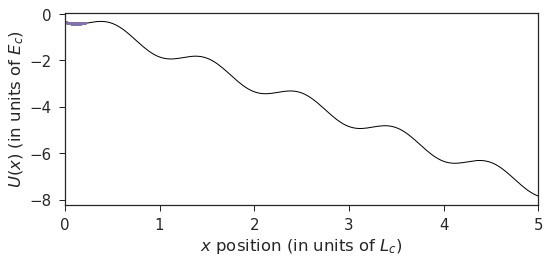

In [104]:
ax = sim.io.plot_potential(xlims=(0,5))
plot_1D_trajectory(sim, ax=ax)

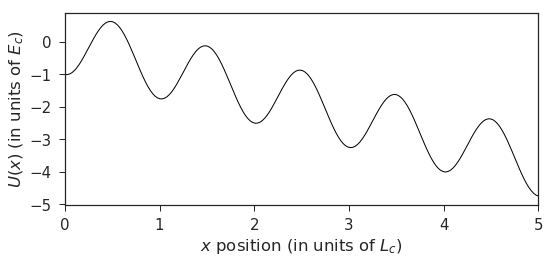

In [16]:
sim.io.plot_potential(xlims=(0,5))

---
# Plotting

## List of (possible) TODO items:

* Make the default figure name be the simulation (output) name
* Parallelize the pandas autocorrelation calculation (or find another option)

### Histogram of thermal-drag force ratio

**Note**: the thermal and drag forces are computed as averages over the simulation ensemble and all timesteps. Thus, the histogram should be symmetric if the particles start off in equilibrium (distributed according to Maxwell-Boltzmann) and asymmetric for other initial conditions (like zero velocity).

In [18]:
def histogram_MSV_over_MSF(sim, figname=None, figdir='data/figs',
                           figscale=1.25, aspect=0.75, **kwargs):
    if figname is None:
        figname = sim.basename.split('/')[1]
    figsize = figscale * plt.figaspect(float(aspect))
    plt.figure(figsize=figsize)
    plt.xlabel(r'$\frac{2m^2\gamma}{\Delta t} \frac{\left\langle\Delta v^2\right\rangle}' + \
               r'{\left\langle\Delta F_{th}^2\right\rangle}$')
    plt.ylabel(r'Probability density of MSV/MSF: {}'.format(figname))
    
    meff = 1 #(rhop+0.5*rhof)/rhof
    
    MSFther_tot = ((sim.thermal_forces.iloc[:,:])**2).mean().mean()
    MSV_tot = (sim.velocities.iloc[:,:]**2).mean().mean()
    MSFdrag_tot = 2*gam0*Tc/(dt/Tc)*meff**2*MSV_tot

    MSFther = ((sim.thermal_forces.iloc[:,:])**2).mean(axis=1)
    MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)
    MSFdrag = 2*gam0*Tc/(dt/Tc)*meff**2*MSV
    MSFdrag_MSFther = MSFdrag.iloc[1:]/MSFther.iloc[1:]
    MSFdrag_MSFther.hist(**kwargs)
    
    plt.tight_layout()
    plt.savefig('{}/hist_MSV-to-MSF_{}.pdf'.format(figdir, figname))

    print 'Average (avg2) mean-square drag force:    {:8.6f} ({:8.6f})'.format(MSFdrag.mean(), MSFdrag_tot)
    print 'Average (avg2) mean-square thermal force: {:8.6f} ({:8.6f})'.format(MSFther.mean(), MSFther_tot)

---

#### $\mathcal{P}\left(\frac{2m^2\gamma\left\langle\Delta v^2\right\rangle/\Delta t}{\left\langle\Delta F_{th}^2\right\rangle}\right)$ for GLE (with single aux variable)

In [ ]:
histogram_MSV_over_MSF(sim, bins=25, density=True)

In [ ]:
histogram_MSV_over_MSF(sim_wt, bins=25, density=True)

In [ ]:
histogram_MSV_over_MSF(sim_wt, bins=25, density=True)

#### $\mathcal{P}\left(\frac{2m^2\gamma\left\langle\Delta v^2\right\rangle/\Delta t}{\left\langle\Delta F_{th}^2\right\rangle}\right)$ for standard LE

In [ ]:
histogram_MSV_over_MSF(sim_le, 'LE_testnewWS', bins=25, density=True)

### 2D real-space plot

### Mean-squared distance vs time

**Note**: the early-time scaling of the MSD will depend on the initial velocity distribution of the simulation ensemble. For example:
* The MSD should grow proportionally to $t^2$ (ballistic) for Maxwell-Boltzmann distributed velocities.
* The MSD should grow proportionally to $t^3$ (superballistic) when the velocities are initialized to zero.

Once the long-time (diffusive) regime is reached, the scaling should always be *linear* in $t$.

In [20]:
def plot_msd(sim, figname=None, figdir='data/figs', figscale=1.25, aspect=0.75, **kwargs):
    if figname is None:
        figname = sim.basename.split('/')[1]
    figsize = figscale * plt.figaspect(float(aspect))
    plt.figure(figsize=figsize)
    plt.title('MSD scaling: {}'.format(figname))
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\left\langle \Delta x^2\right\rangle$')
    
    t = sim.times.values
    Xtothe2 = (sim.positions.iloc[:,:]**2).mean(axis=1)  # average over the ensemble
    plt.loglog(t[1:], Xtothe2.iloc[1:], label='simulation ensemble',  **kwargs)
    
    # Plot asymptotes
    t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
    plt.loglog(t_asymp, 1.0e-6*t_asymp**2, ls='--', label='$t^2$ (ballistic)')
    plt.loglog(t_asymp, 1.5e-6*t_asymp, ls='--', label='$t$ (diffusive)')

    plt.legend()
    plt.savefig('{}/MSD_{}.pdf'.format(figdir, figname))

---

#### MSD for GLE (with single aux variable)

In [ ]:
plot_msd(sim)

In [ ]:
plot_msd(sim2)

In [ ]:
plot_msd(sim_wt)

In [ ]:
plot_msd(sim_wt)

#### MSD for standard LE

In [ ]:
plot_msd(sim_le, 'MSD_LE_testnewWS')

---
### Mean-squared velocity vs time

In [22]:
def plot_msv(sim, figname=None, figdir='data/figs', figscale=1.25, aspect=0.75, **kwargs):
    if figname is None:
        figname = sim.basename.split('/')[1]
    figsize = figscale * plt.figaspect(float(aspect))
    plt.figure(figsize=figsize)
    plt.title('MSV scaling: {}'.format(figname))
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\left\langle \Delta v^2\right\rangle$')
    
    t = sim.velocities.index.values
    MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)  # average over the ensemble
    plt.loglog(t, MSV, label='simulation ensemble',  **kwargs)
    
    # Plot asymptotes
    t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
    MSV_eq = kB*Te/m *(Mc/Ec) * np.ones_like(t_asymp)
    plt.loglog(t_asymp, MSV_eq, label='MSV (equilibrium)')
    plt.loglog(t_asymp, MSV_eq/1.5, label='MSV (eq using effective mass)')

    plt.legend()
    plt.savefig('{}/MSV_{}.pdf'.format(figdir, figname))

In [28]:
def plot_msv_smooth(sim, window, win_type='triang', percentile=0.95,
                    figname=None, figdir='data/figs',
                    figscale=1.5, aspect=0.75, **kwargs):
    if figname is None:
        figname = sim.basename.split('/')[1]
    figsize = figscale * plt.figaspect(float(aspect))
    plt.figure(figsize=figsize)
    plt.title('MSV scaling: {}'.format(figname))
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\left\langle \Delta v^2\right\rangle$')
    
    lower = (1 - percentile)/2
    upper = (1 - lower)

    t = sim.velocities.index.values
    Vtothe2 = (sim.velocities**2)
    r = Vtothe2.rolling(window=window, axis=0, win_type=win_type)
    rolling_Vtothe2 = r.mean()
    mean_MSV = rolling_Vtothe2.mean(axis=1)
    std = rolling_Vtothe2.std(axis=1)
    low = mean_MSV - std
    high = mean_MSV + std
    high = rolling_Vtothe2.std(axis=1)
#     low = rolling_Vtothe2.quantile(q=lower, axis=1)
#     high = rolling_Vtothe2.quantile(q=upper, axis=1)

    plt.loglog(t, mean_MSV, label='simulation ensemble',  **kwargs)
    ax = plt.gca()  # get current axis to which 'fill_between' will be plotted
    ax.fill_between(low.index, low, high, alpha=0.3)
    
    # Plot asymptotes
    t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
    MSV_eq = kB*Te/m *(Mc/Ec) * np.ones_like(t_asymp)
    plt.loglog(t_asymp, MSV_eq, label='MSV (equilibrium)')
    plt.loglog(t_asymp, MSV_eq/1.5, label='MSV (eq using effective mass)')
    
    plt.tight_layout()
    plt.legend()
    plt.savefig('{}/MSV_smooth_{}.pdf'.format(figdir, figname))

---

#### MSV for GLE (with single aux variable)

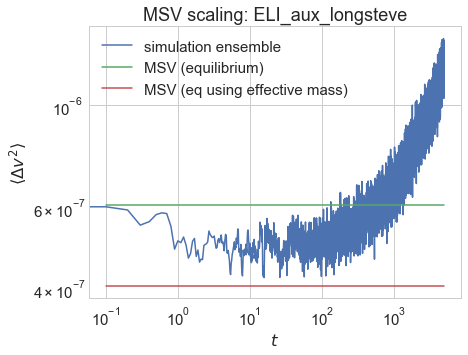

In [48]:
plot_msv(sim)

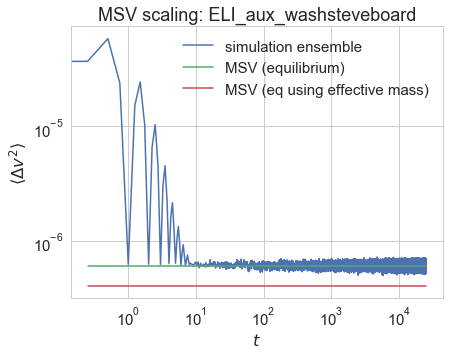

In [14]:
plot_msv(sim2)

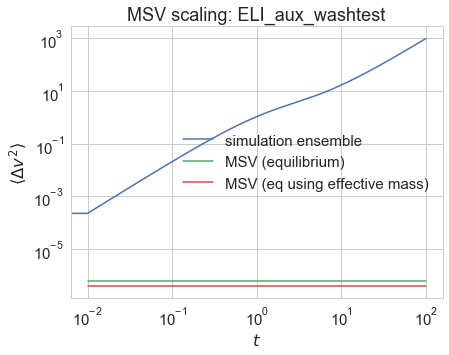

In [23]:
plot_msv(sim_wt)

In [ ]:
plot_msv_smooth(sim, 10, win_type='triang')

#### MSD for standard LE

In [ ]:
plot_msv(sim_le, 'MSV_LE_testnewWS')

### Velocity distribution at various times

In [13]:
# Can also think about writing a function or something that converts easily
#   b/w integer indexing of trajectories and the simulation time (either
#   nondimensional time or in, say, nanoseconds?)

def velocity_dist(sim, tidx, figname=None, figdir='data/figs', figscale=1.25, aspect=0.75,
                  append_time=True, hist=True, kde=True, hist_kwargs=None, kde_kwargs=None):
    if figname is None:
        figname = sim.basename.split('/')[1]
    figsize = figscale * plt.figaspect(float(aspect))
    plt.figure(figsize=figsize)
    plt.title(r'Velocity distribution: {}'.format(figname))
    plt.xlabel(r'$v$')
    plt.ylabel(r'$\mathcal{P}(v)$')
    t_eql_str = '$t = {}$'.format(tidx)
    
    Vall = sim.velocities
    Vt = Vall.iloc[tidx,:]
    
    if hist:
        Vt.hist(label=r''+t_eql_str+' (hist)', **hist_kwargs)
    if kde:
        Vt.plot.kde(label=r''+t_eql_str+' (KDE)', **kde_kwargs)

    label =  'Mean: {:11.6e}\n'.format(Vt.mean())
    label += 'SD:   {:11.6e}'.format(Vt.std())
    plt.text(1, 0.5, label, fontsize=14, bbox=dict(facecolor='gray', alpha=0.75),
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)

    plt.legend()
    plt.tight_layout()
    
    if append_time:
        figname = '{}_tidx={}'.format(figname, tidx)
    plt.savefig('{}/PofV_{}.pdf'.format(figdir, figname))

---

#### $\mathcal{P}(v,t)$ for GLE (with single aux variable)

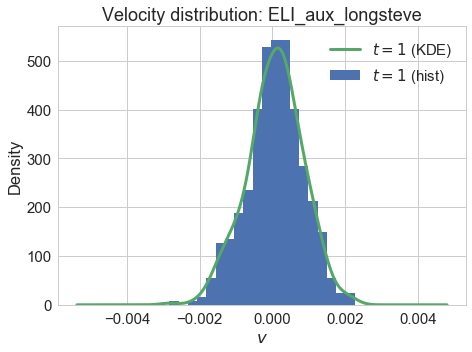

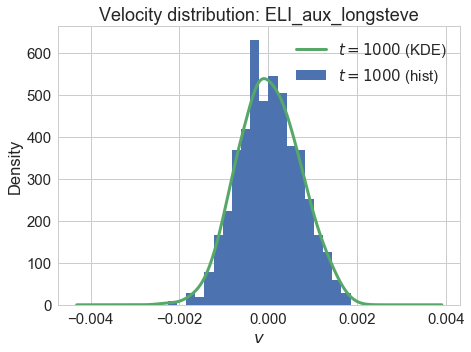

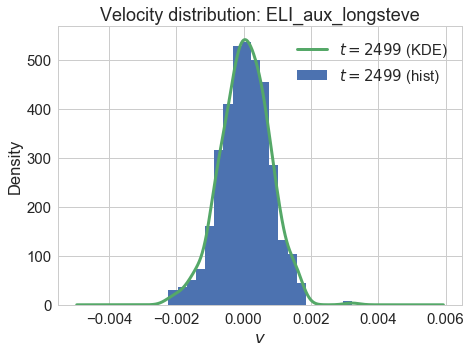

In [51]:
hist_kwargs = {'bins' : 20, 'density' : True}
kde_kwargs = {'bw_method' : 'silverman', 'lw' : 3}
kwargs = {'hist_kwargs' : hist_kwargs, 'kde_kwargs' : kde_kwargs}
velocity_dist(sim, 1, **kwargs)
velocity_dist(sim, 1000, **kwargs)
velocity_dist(sim, 2499, **kwargs)

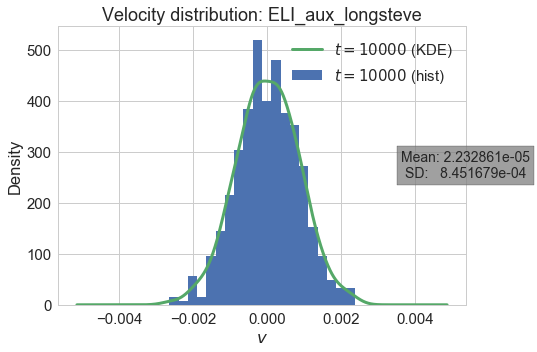

In [78]:
velocity_dist(sim, 10000, **kwargs)

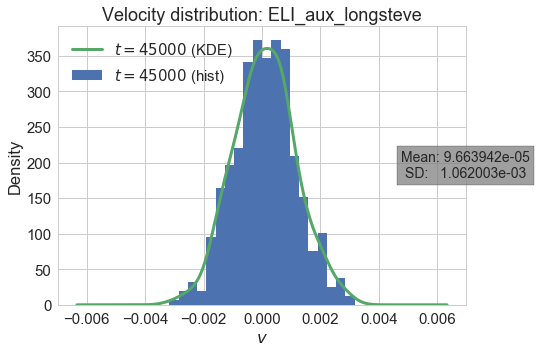

In [79]:
hist_kwargs = {'bins' : 20, 'density' : True}
kde_kwargs = {'bw_method' : 'silverman', 'lw' : 3}
kwargs = {'hist_kwargs' : hist_kwargs, 'kde_kwargs' : kde_kwargs}
velocity_dist(sim, 45000, **kwargs)

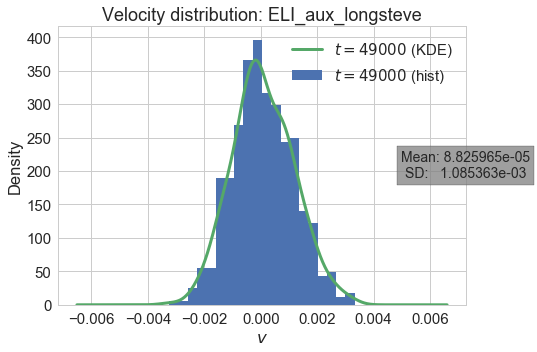

In [80]:
hist_kwargs = {'bins' : 20, 'density' : True}
kde_kwargs = {'bw_method' : 'silverman', 'lw' : 3}
kwargs = {'hist_kwargs' : hist_kwargs, 'kde_kwargs' : kde_kwargs}
velocity_dist(sim, 49000, **kwargs)

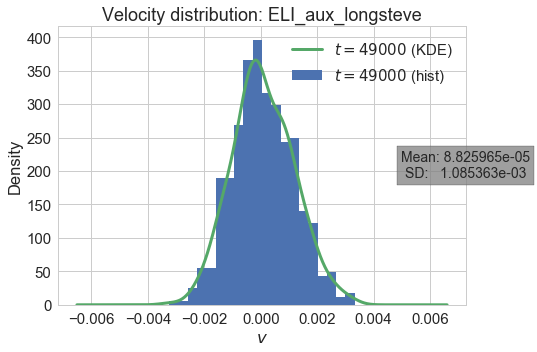

In [80]:
hist_kwargs = {'bins' : 20, 'density' : True}
kde_kwargs = {'bw_method' : 'silverman', 'lw' : 3}
kwargs = {'hist_kwargs' : hist_kwargs, 'kde_kwargs' : kde_kwargs}
velocity_dist(sim_wt, 49000, **kwargs)

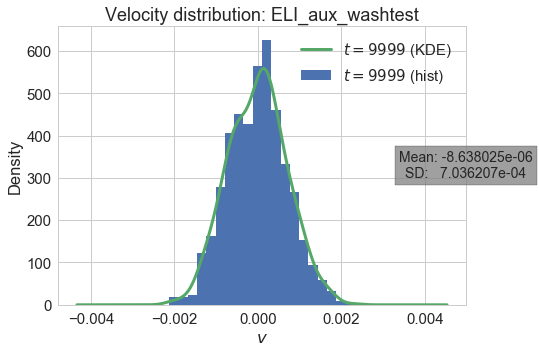

In [14]:
hist_kwargs = {'bins' : 20, 'density' : True}
kde_kwargs = {'bw_method' : 'silverman', 'lw' : 3}
kwargs = {'hist_kwargs' : hist_kwargs, 'kde_kwargs' : kde_kwargs}
velocity_dist(sim_wt, 9999, **kwargs)

#### $\mathcal{P}(v,t)$ for standard LE

In [ ]:
hist_kwargs = {'bins' : 20, 'density' : True}
kde_kwargs = {'bw_method' : 'silverman', 'lw' : 3}
kwargs = {'hist_kwargs' : hist_kwargs, 'kde_kwargs' : kde_kwargs}
velocity_dist(sim_le, 1, 'PofV_LE_2600ns', **kwargs)
velocity_dist(sim_le, 10000, 'PofV_LE_2600ns', **kwargs)
velocity_dist(sim_le, 39000, 'PofV_LE_2600ns', **kwargs)

---
## Autocorrelations

In [ ]:
import multiprocessing as mp
from pandas.plotting import autocorrelation_plot

sys.path.append('src/util/backup_and_examples')
import parallelizer_v3 as pv3

In [ ]:
def worker(series):
    return autocorrelation_plot(series).lines[5].get_ydata()

### Position autocorrelation

### Velocity autocorrelation

In [ ]:
df_V_list = [sim.velocities['Run {}'.format(i+1)]['vx'] for i in xrange(Nrep)]

In [ ]:
par_v3_map_async = pv3.Parallelizer(worker, df_V_list[:1], data_size=1)

In [ ]:
par_v3_map_async.run(N_WORKERS=4, TASK_SIZE=1, method='map_async')
pv3_map_async = par_v3_map_async.results

#### Extract `xy` data from the autocorrelation plot

In [ ]:
vacf_line = vacf_plt.lines[5]  # the last element is the one containing the autocorr data
vacf_yvals = vacf_line.get_ydata()

In [ ]:
autocorrelation_plot(V1)

---

---

---

# Testing

In [ ]:
t = sim.velocities.index.values
MSV = (sim.velocities.iloc[:,:]**2).mean(axis=1)

t_asymp = np.logspace(np.log10(t[1]), np.log10(t[-1]), 100)
MSV_eq = kB*Te/m *(Mc/Ec) * np.ones_like(t)

In [ ]:
t = sim.times.values
MSD = (sim.positions.iloc[:,:]**2).mean(axis=1)
MSV2 = (MSD - np.roll(MSD, 1)) / (dt/Tc)
MSV3 = sim.positions.iloc[:,:]

In [ ]:
plt.figure(figsize=figsize)
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle \Delta v^2(t)\right\rangle$')
plt.loglog(t, MSV, label=r'$\left\langle \Delta v^2(t)\right\rangle$ (calculated)')
plt.loglog(t[1:], MSD.iloc[1:]/t[1:], label=r'$\left\langle \Delta x^2(t)\right\rangle / t$')
plt.loglog(t[1:-1], MSV2.iloc[1:-1], label=r'$\left\langle (\Delta x(t+\Delta t) -\Delta x(t))/\Delta t\right\rangle$')
plt.loglog(t, MSV_eq, label=r'$\left\langle \Delta v^2\right\rangle_\mathrm{eq}$')
plt.loglog(t, MSV_eq/1.5, label=r'$\left\langle \Delta v^2\right\rangle_\mathrm{eq}$ (using effective mass)')
plt.legend()

In [ ]:
def df_rolling_autocorr(df, window, lag=1):
    """Compute rolling column-wise autocorrelation for a DataFrame."""

    return (df.rolling(window=window).corr(df.shift(lag))).dropna() # could .dropna() here

In [ ]:
df_rolling_autocorr(df_V1, window=21).head()

### Speed distribution ($V^2$)

---

---

---
## Set up `distributed`

If you create an client without providing an address it will start up a local scheduler and worker for you:
```
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client
```

**Notes for remote machines**:
* Make sure that `dask-scheduler` has been run at the cmd line on the machine acting as server.
  * Just running `dask-scheduler` on a local machine is sufficient for a local scheduler
* Make sure that something like `dworker --nprocs 2 --nthreads 1 10.206.30.254:8786` has been run at the cmd line on the target machine.
  * Run `ifconfig | grep inet` at the cmd line of target machine to check its IP address.
```
from dask.distributed import Executor, progress
ex = Executor('10.206.30.254:8786')
print ex
```

#### Example use of `map` and `submit`

```
>>> A = client.map(my_func1, range(10))
>>> B = client.map(my_func2, A)
>>> total = client.submit(my_func3, B)
>>> total.result()
```

#### Test picklability of sim object

```
from cloudpickle import dumps, loads
loads(dumps(sim))
```

---

---

In [ ]:
def print_params(**kwargs):
    
    print 'mass = {:7.4e} kg'.format(m)
    print 'gam0 = {:7.4e} 1/s'.format(gam0)
    print 'nu1  = {:7.4e} 1/s'.format(nu1)
    print 'V0   = {:7.4e} J/m'.format(V0)
    print 'L0   = {:7.4e} m'.format(L0)
    print 'C0   = {:7.4e} J/m'.format(C0)
    
    print '\n'
    print 'Lc  = {:7.4e} m'.format(Lc)
    print 'Mc  = {:7.4e} kg'.format(Mc)
    print 'Tc  = {:7.4e} s'.format(Tc)
    print 'Nc  = {:7.4e} kg/m^3'.format(Nc)
    print 'Vc  = {:7.4e} m/s'.format(Vc)
    print 'Ec  = {:7.4e} kg(m/s)^2'.format(Ec)
    print 'Fc  = {:7.4e} kg m/s^2'.format(Fc)
    print 'Tec = {:7.4e} K'.format(Tec)
    print '\n','dt  = {:7.4e} s'.format(dt)

---

In [ ]:
sys.path.append('util')

import itertools as it
import parallelizer_v2 as pv2
import parallelizer_v3 as pv3

In [ ]:
N_WORKERS = 2
TASK_SIZE = 5

### Generate a bunch of `GLESimulation` objects

In [ ]:
for i in xrange(N_SIMS):
    sims[i].close_trj_files()

In [ ]:
N_SIMS = 10
sims = []
seeds = np.zeros(N_SIMS, dtype=np.int32)

run_kwargs = {"nsteps"   : 1000000,
              "tmpsize"  : 1000000,
              "ntout"    : 10,
              "printout" : 100}

for i in xrange(N_SIMS):
    seeds[i] = i + 987654
    sim = gle.GLESimulation(outname='data/ELI_testwash_{:03n}'.format(i+1), method='ELI',
                         N=N, D=1, T=T, L=L, R=R, rhop=rhop, rhof=rhof, eta=eta,
                         gam0=gam0, nu1=nu1, dt=dt, seed=seeds[i])
    sim.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L/Lc)
    sim.add_integrator('ELI')
    sims.append(sim)
print(' >>> {} simulations initialized.'.format(N_SIMS))

#### `GLEEnsembleSimulator`

In [ ]:
import GLEEnsembleSimulator as gle_ens

In [ ]:
N_SIMS = 2
sims = []
seeds = np.zeros(N_SIMS, dtype=np.int32)

run_kwargs = {"nsteps"   : 1000000,
              "tmpsize"  : 1000000,
              "ntout"    : 10,
              "printout" : 100}

for i in xrange(N_SIMS):
    seeds[i] = i + 987654
    
ensemble = gle_ens.GLEEnsembleSimulator(N_SIMS, outname='data/ELI_testwash_{:03n}'.format(i+1), method='ELI',
                     N=N, D=1, T=T, L=L, R=R, rhop=rhop, rhof=rhof, eta=eta,
                     gam0=gam0, nu1=nu1, dt=dt, seed=seeds[i])
ensemble.add_force(force.WashboardForce, 'washboard', V0=V0, L0=L/Lc)
ensemble.add_integrator('ELI')

print(' >>> {} simulations initialized.'.format(N_SIMS))

In [ ]:
import pathos.pools

In [ ]:
pathos.pools.ProcessPool?

In [ ]:
ensemble.simulate(**run_kwargs)

#### Parallelizer v2: `multiprocessing`

In [ ]:
par_v2 = pv2.ParallelRun(sims, run_kwargs)

In [ ]:
par_v2.run(N_WORKERS=N_WORKERS)
pv2_mp = par_v2.results

#### Parallelizer v3: `map_async`

In [ ]:
par_v3_map_async = pv3.Parallelizer(hausdorff_c2, path_pairs, data_size=N_PAIRS)

In [ ]:
par_v3_map_async.run(N_WORKERS=N_WORKERS, TASK_SIZE=TASK_SIZE, method='map_async')
pv3_map_async = par_v3_map_async.results

#### Parallelizer v3: `imap`

In [ ]:
par_v3_imap = pv3.Parallelizer(hausdorff_c2, path_pairs, data_size=N_PAIRS)

In [ ]:
par_v3_imap.run(N_WORKERS=N_WORKERS, TASK_SIZE=TASK_SIZE, method='imap')
pv3_imap = par_v3_imap.results

#### Parallelizer v3: `imap_unordered`

In [ ]:
par_v3_imap_unord = pv3.Parallelizer(hausdorff_c2, path_pairs, data_size=N_PAIRS)

In [ ]:
par_v3_imap_unord.run(N_WORKERS=N_WORKERS, TASK_SIZE=TASK_SIZE, method='imap_unordered')
pv3_imap_unord = par_v3_imap_unord.results

---

---
## `np.take()` is faster than fancy indexing...

In [ ]:
import numpy as np
import random

arrF = np.random.randn(10000, 5)
arrC = np.random.randn(5, 10000)
indexer = np.arange(10000)
random.shuffle(indexer)

In [ ]:
timeit arrF[indexer]

In [ ]:
timeit arrF.take(indexer, axis=0)

In [ ]:
timeit arrC[:,indexer]

In [ ]:
timeit arrC.take(indexer, axis=1)

In [ ]:
arrC.take(np.arange(10), axis=1)

---

---
## Pandas `eval()` is fast as fuck if you're doing a certain set of DataFrame calculations

In [ ]:
import numba

def square_every_value_nonumba(x):
    return x**2 + 1/(x-2*x**3)**2

@numba.vectorize
def square_every_value_withnumba(x):
    return x**2 + 1/(x-2*x**3)**2

@numba.jit(nopython=True, parallel=True)
def square_every_value_withnumbajit(x):
    return x**2 + 1/(x-2*x**3)**2

In [ ]:
%timeit square_every_value_nonumba(sim_nc.velocities)

In [ ]:
%timeit square_every_value_withnumba(sim_nc.velocities.values)

In [ ]:
%timeit square_every_value_withnumbajit(sim_nc.velocities.values)

In [ ]:
square_every_value_withnumbajit(sim_nc.velocities.values)

In [ ]:
df = sim_nc.velocities

In [ ]:
%timeit pd.eval('df**2 + 1./(df-2.*df**3.)**2')

In [ ]:
pd.eval('df**2 + 1./(df-2.*df**3.)**2')

---

## Assumed dynamical form

The generalized Langevin dynamics (GLD) equation of motion is represented in the extended/auxiliary variable formalism by the following set of coupled, first-order SDEs:

$$
\dot{x} = v(t)
$$

$$
\dot{v} = \frac{1}{m}F(x(t)) - \frac{1}{m}\sum_{k=1}^N \sigma_k(t) - \frac{c_0}{m}\:\! v(t) + \hat{\xi}_0(t),
$$

$$
\dot{\sigma}_k = -\frac{1}{\tau_k}\sigma_k(t) - \frac{c_k}{\tau_k}v(t) + \frac{1}{\tau_k}\hat{\xi}_k(t)
$$

where $x$, $v$, and $m$ are, respectively, the main particle's position, velocity and mass, $c_0 = \sum c_k$ with $\gamma_0 = c_0/m = 1/\tau_0$ being the collision frequency for the main particle, $\gamma_k = c_k/m = 1/\tau_k$ is the collision frequency for auxiliary particle $k$, and $\hat{\xi}_0$ and $\hat{\xi}_k$ are thermal noise terms for the main and $k^\text{th}$ particle, respectively. There are $N$ auxiliary particles, each subject to an independent noise process, $\xi_k$; $\hat{\xi}_0$ and $\hat{\xi}_k$ describe $N+1$ zero-mean, white Gaussian noise processes with autocorrelations given by

$$
\left\langle\hat{\xi}_0(t)\hat{\xi}_0(t')\right\rangle = \sum_{k=1}^N \frac{2k_BT c_k}{m}\delta(t-t').
$$

$$
\left\langle\hat{\xi}_k(t)\hat{\xi}_k(t')\right\rangle = \frac{2k_BT c_k}{\tau_k^2}\delta(t-t').
$$

Since $\xi_0$ is calculated from a weighted sum of the $\xi_k$, the $N$ auxiliary noise processes, there are $N$ independent stochastic samples required per timestep.

---

## Numerical discretization based on modified Langevin Impulse integration

An LI-like numerical algorithm can be written in five steps<sup>[1](#footnote1)</sup>:

**Step 1**: Update velocity by $\Delta t/2$

$\qquad
v^{n+1/2} = v^n + \frac{\Delta t}{2}\left[\frac{1}{m}F(x^n) - \sum_{k=1}^N s_k^n\right]
$

**Step 2**: Compute impulse velocity at $\Delta t(n+1/2)$ (dissipative + noise terms)

$\qquad
\Delta v^{n+1/2} = -(1-\theta_0)\:\! v^{n+1/2} + \alpha_0\sqrt{\frac{k_BT}{m}} \,\mathcal{W}_0^n
$

**Step 3**: Update position by $\Delta t$

$\qquad
x^{n+1} = x^n + \Delta t\left(v^{n+1/2} + \frac{1}{2}\Delta v^{n+1/2}\right)
$

**Step 4**: Update auxiliary variables (velocities) by $\Delta t$

$\qquad
s_k^{n+1} = \theta_k s_k^n - (1-\theta_k)\:\!\gamma_k v^{n+1/2} + \alpha_k\sqrt{\frac{k_BT}{m}\gamma_k} \,\mathcal{W}_k^n
$

**Step 5**: Update velocity by $\Delta t/2$

$\qquad
v^{n+1} = \left[v^{n+1/2} + \Delta v^{n+1/2}\right] + \frac{\Delta t}{2}\left[\frac{1}{m}F(x^{n+1}) - \sum_{k=1}^N s_k^{n+1}\right]
$

where

$\quad
\theta_0 = e^{-\gamma_0 \Delta t} \qquad\text{and}\qquad \alpha_0 = \sqrt{\frac{(1-\theta_0^2)}{2}}
$

$\quad
\theta_k = e^{-\nu_k \Delta t}  \qquad\text{and}\qquad \alpha_k = \sqrt{\frac{(1-\theta_k^2)\:\!\nu_k}{2}} \quad\text{or}\quad \alpha_k = \sqrt{\frac{(1-\theta_k)^2}{\Delta t}}
$

### Viscoelasticity

Leads to the appearance of *subdiffusion*, which is a consequence of the energy of some system (e.g. a Brownian-like particle) being *stored* in the *internal* degrees of freedom (DoFs) in the (constituents of the) bath or surrounding fluid medium (e.g., potential energies of bond bending/streching, polarization/electrostatics, etc.). This is a consequence of intentionally or indirectly coarse-graining out DoFs in the detailed structure of the bath medium. Such internal DoFs may, separately, involve many motions and charcteristic length scales typically *below* the characteristic spatiotemporal scales of interest (i.e., the particle size and temporal scale set by the thermal velocity), but, collectively, may return some proportion of the energy done by the system on the bath *back* to the system on timescales of interest. The key is that the energy that's returned to the system must have some signature of the energy that was originally transferred to the bath. That is, the give-and-take must be *coherent*, as in, ordered (and not random) to some extent; and the storage of that energy in the bath DoFs must have some "coherence time", a window of time during which that energy may be partially repaid to the system. The energy that eventually makes its way back to the relevant observation scales will appear as correlated motions in the system. These correlations are often described as "memory" in the system and correspond to *non-Markovian* behavior; mathematically speaking, the equations of motion often contain an integral over past states with some memory kernel (unless Markovian embedding, yo). In the case of subdiffusion, the original energy given to the bath, $E_\mathrm{given}$, is returned in such a way that net energy returned to the system, $E_\mathrm{returned} = \alpha E_\mathrm{given}$ (for $0 < \alpha < 1$) flows in the *opposite* direction:

$$
    \nabla \left\langle E_\mathrm{returned} \right\rangle = -\alpha \nabla \left\langle E_\mathrm{given}\right\rangle.
$$

In the case where the direction of the returned energy is uncorrelated with the original energy given, the force is a Markovian stochastic process.

### Hydrodynamics

Leads to the appearance of *superdiffusion*, which is a consequence of a system's energy being stored in the bath on length/time scales typically *above* the characteristic spatiotemporal scale of interest. Many such cases can be visualized in terms of a system generating hydrodynamic flows that persist for long enough to return energy to the system (which generated it in the first place). As with viscoelastic behavior, motions appear correlated because energy is stored in bath in collective inertial degrees of freedom, like in the directed kinetic energy of a hydrodynamic flow generated by entrainment (or a similar process when at low Re number). Such collective motions may return energy to the system on time scales of observational interest, again leading to correlation as in the viscoelastic case. However, superdiffusive processes, while they may apparently retard the motion of a particle on shorter time scales—due to the work it takes, for instance, for a system to "get the surrounding fluid going"—are a result of coherently returning some of the energy originally given to the bath (from the system) and applying it to the system in the *same* direction in which it was given (note the sign difference from above):

$$
    \nabla \left\langle E_\mathrm{returned} \right\rangle = \alpha \nabla \left\langle E_\mathrm{given}\right\rangle.
$$

Sub- and super-diffusive processes both have the property of non-Markovianity, which arises from the time delay between the giving of energy to the bath (work done by system on bath) and the eventual return of the energy to the system (work done by bath on system).


It seems clear that such non-Markovian processes involve a delay between the time when energy is transferred from a system to its environment (what I've been generically calling the "bath") and the time when some *coherent* fraction of that energy is returned to the system. The primary differences between sub- and super-diffusion is *where* and *how* the exchange of energy takes place:
* viscoelasticity; subdiffusion; collective action of potential energies of bath DoFs (spring appox!); opposite direction of original work done on bath
* hydrodynamics/advective transport; superdiffusion; collective action of kinetic motions of bath DoFs; same direction of original work done on bath

### Equilibrium systems

If observation timescales greatly exceed this energy exchange time delay (i.e. exceed the decoherence time b/w system and bath), the exchange appears instantaneous and the process is approximately Markovian. Such processes are said to be purely *diffusive*; the give-and-take between the system and bath is directionally uncorrelated/unbiased, homogeneous, and local in time (is it effectively nonlocal in space, though? Like, as in how the energy is homogenized in the bath "instantaneously"). In the case of a purely "equilibrium" process, the canonical fluctuation-dissipation relation describes a kind of equivalence between dissipative forces on the particle (work done by particle on bath) and the thermal forces on the particle (work on by bath on particle) such that no net work is done in the long-time or ensemble limit; this is tantamount to global system-bath energy conservation and is closely related to ergodicity.



### Fun note

The spread of the prob. dist for an equilibrium process is described by a Fokker-Planck eqn, describing isotropic Gaussian spreading of possible states of a system; this is an unbiased process that defines the line between processes finite (visco or w/e) and infinite (hydro) in phase-spatial extent. With hydrodynamics, motion can remain coherent on finite timescales, so the probability flows in a directed manner in phase or whatever space, leading to things like probability "tubes"; hyperbolicity? Lagrangians? With viscoelasticity, the probability distribution remains finite in extent; ellipticity? Hamiltonians/Boltzmann factors?

---